##### Copyright 2019 The TensorFlow Authors.

### Setup

In [1]:
import tensorflow as tf
tf.__version__
# To generate GIFs
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

2023-08-30 18:35:24.973173: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 18:35:25.314595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 18:35:26.462148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


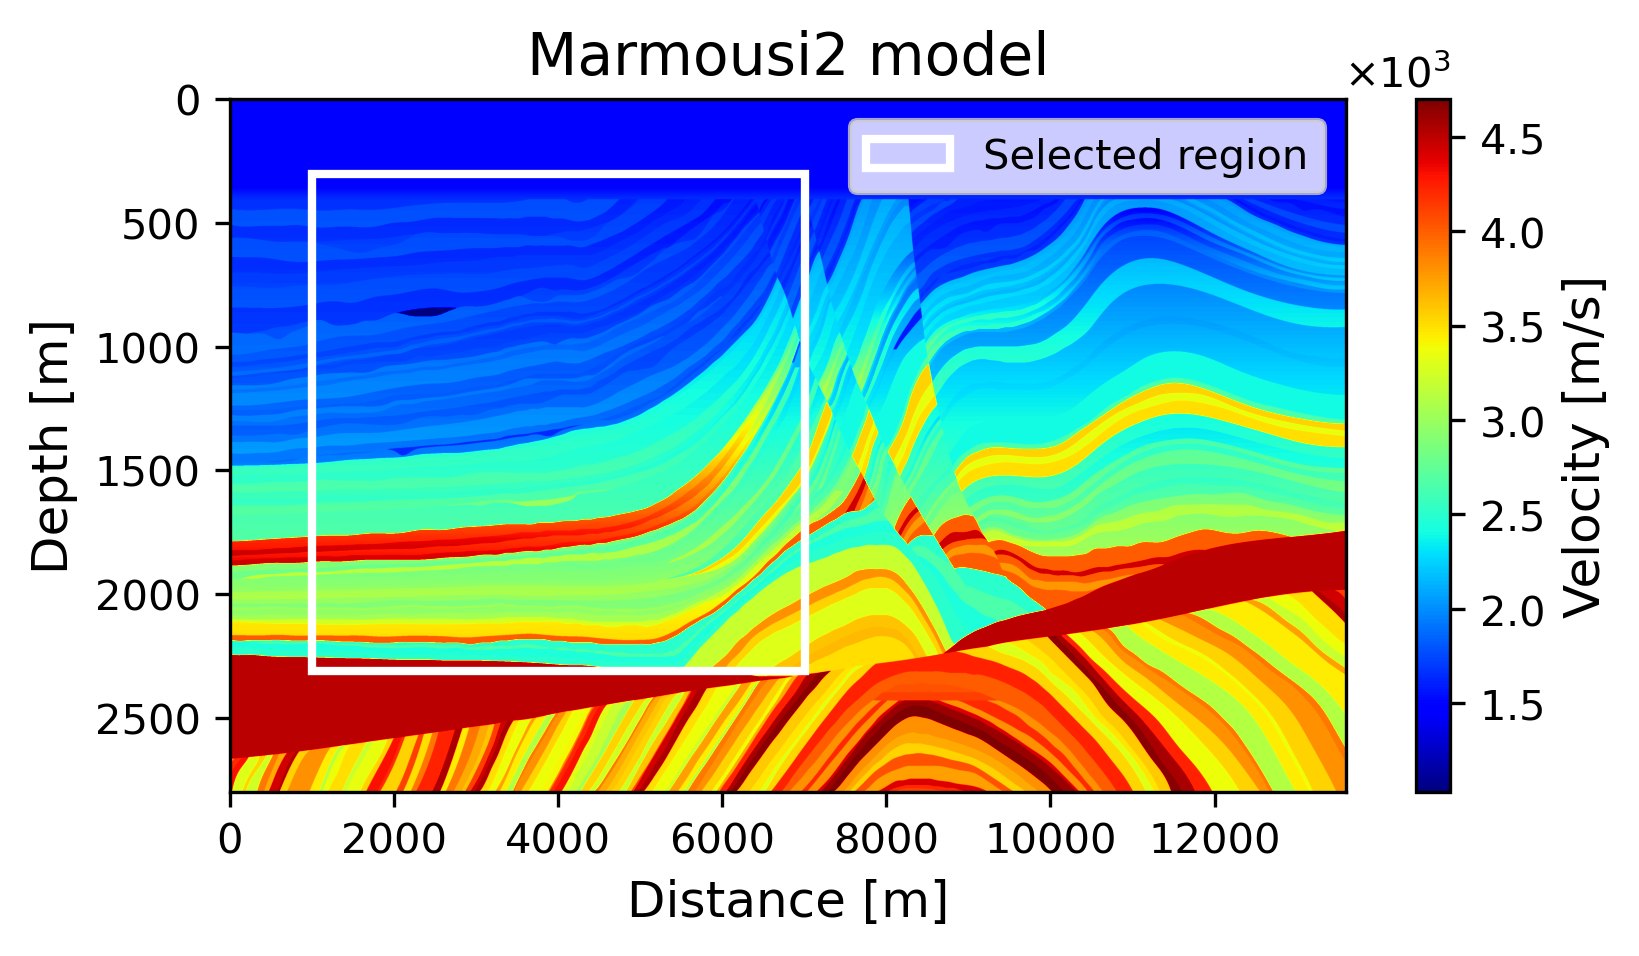

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Assuming you have a dataset with size (nz, nx) = (2801, 13601)
nzz, nxx = 2801, 13601
vel = readbin('../dataset/marm.dat',nzz,nxx)
vel = 1000 * vel
vmin,vmax = vel.min(),vel.max()


# Downsampling and window selection
incz,incx = 10,10
#fz,fx     = 300,4000
fz,fx     = 300,1000
nz2,nx2   = 201,601
nsmo  = 23
velselect = vel[fz:fz+nz2*incz:incz,fx:fx+nx2*incx:incx]

plt.figure(figsize=(6,3),dpi=300)
plt.imshow(vel,vmin=vmin,vmax=vmax,cmap='jet',aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("Velocity [m/s]", fontsize=12)

# Define the coordinates and size of the box
x, y, width, height = fx, fz, nx2*incx, nz2*incz
# Create a red box using a Rectangle patch
rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='w', facecolor='none',label="Selected region")
# Add the box to the current axes
plt.gca().add_patch(rect)
plt.xlabel('Distance [m]', fontsize=12)
plt.ylabel('Depth [m]', fontsize=12)
plt.title("Marmousi2 model",fontsize=14)
plt.legend()
plt.show()

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

(100000, 28, 28)


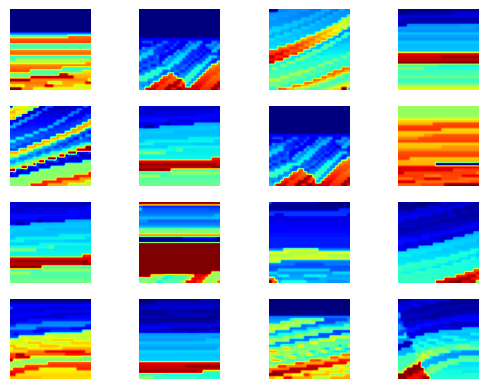

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Assuming you have a dataset with size (nz, nx) = (2801, 13601)
nzz, nxx = 2801, 13601
vel = readbin('../dataset/marm.dat',nzz,nxx)
vel = 1000 * vel

# Define the size of the cropped region
nz, nx = 28, 28
ratio = 30
crop_size = (ratio*nz, ratio*nx)

# Define the number of regions to be cropped
num_regions = 100000

# Generate random indices for the top-left corner of the regions
random_rows = np.random.randint(0, nzz - crop_size[0], num_regions)
random_cols = np.random.randint(0, nxx - crop_size[1], num_regions)

# Initialize an array to store the cropped regions
cropped_regions = np.zeros((num_regions, nz, nx))

# Crop the regions from the dataset
for i in range(num_regions):
    start_row, start_col = random_rows[i], random_cols[i]
    end_row, end_col = start_row + crop_size[0], start_col + crop_size[1]
    cropped = vel[start_row:end_row, start_col:end_col]
    cropped_regions[i] = cropped[::ratio,::ratio]

# Now, cropped_regions contains 100 randomly selected regions with size (201, 601)

print(cropped_regions.shape)
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(cropped_regions[np.random.randint(100),:,:],cmap='jet')
  plt.axis('off')

In [3]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = cropped_regions
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

vmin, vmax = np.min(train_images),np.max(train_images)
def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = num_regions
BATCH_SIZE = 64
nz=100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

-1.0 1.0


2023-07-26 18:23:47.534990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-26 18:23:47.547660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-26 18:23:47.547713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-26 18:23:47.549600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-26 18:23:47.549634: I tensorflow/compile

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(nz,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

In [5]:
generator = make_generator_model()

noise = tf.random.normal([1, nz])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

: 

: 

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 500
noise_dim = nz
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(inverse_norm(predictions[i, :, :, 0],vmin,vmax),cmap='jet')
      plt.colorbar()
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
from scipy.ndimage import gaussian_filter

plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4, 4, i+1)
  z = tf.random.normal([1, noise_dim])
  Gz = generator(z, training=False)[0,:,:,0]
  Gz_filtered = gaussian_filter(Gz, sigma=2)
  plt.imshow(inverse_norm(Gz_filtered,vmin,vmax),cmap='jet')
  plt.colorbar()
  plt.axis('off')


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)